In [1]:
import warnings
warnings.filterwarnings('ignore')

## 14. モデルの評価
アルゴリズムをチューニングし、モデルの性能を評価することで、よいモデルを構築する。

### パイプライン
schikit-learnのPiptlineというクラスを用いれば、任意の個数の変換ステップを含んだモデルを適合させ、  
そのモデルを適用して新しいデータを予測できるようになる。

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd

cancer = load_breast_cancer()
#X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='lbfgs'))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(pipe_lr.score(X_test, y_test))

0.9370629370629371


複数の特徴量を1つにまとめあげるには、FeatureUnionを使う。  
ここで、前処理としてPCAにより作成された2つの成分と元々の特徴量を並列に準備し統合する例を示す。

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

preprocess = FeatureUnion([('row', FunctionTransformer(lambda x: x, validate=False)),
                           ('pca', PCA(n_components=2))])

pipe_lr2 = Pipeline([("preprocess", preprocess),
                     ("classifier", LogisticRegression())])
pipe_lr2.fit(X_train, y_train)
y_pred = pipe_lr2.predict(X_test)
print(pipe_lr2.score(X_test, y_test))

0.951048951048951


C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


カラムごとに異なる前処理を行う場合はColumnTransformerを使用する。

In [9]:
from sklearn.compose import ColumnTransformer

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
X_train, X_test, y_train, y_test = train_test_split(X, y)

cols1 = [s for s in X.columns if 'mean' in s]
cols2 = [s for s in X.columns if 'worst' in s]

transformer1 = Pipeline(steps=[
    ('scaler', StandardScaler())])

transformer2 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))])

preprocess = ColumnTransformer(
    transformers=[
        ('tr1', transformer1, cols1),
        ('tr2', transformer2, cols2)])

pipe_lr2 = Pipeline([("preprocess", preprocess),
                     ("classifier", LogisticRegression())])
pipe_lr2.fit(X_train, y_train)
y_pred = pipe_lr2.predict(X_test)
print(pipe_lr2.score(X_test, y_test))

0.972027972027972


### モデルの性能の評価
#### ホールドアウト法
効果的な方法は、データを訓練データセット、検証データセット、テストデータセットの3つに分割することである。  
訓練データセットはさまざまなモデルの学習に使い、モデルの選択のために、検証データセットを使ってモデルの性能を評価する。  
最終的な性能評価には、テストデータセットを用いる。  
ただし、元の訓練データセットを訓練サブセットと検証サブセットにどのように分割するかによって、性能の評価に影響が及ぶ場合がある。  
  
#### k分割交差検証法(k-fold cross-validation)
非復元抽出を用いて、訓練データセットをランダムに$k$個に分割する。  
そのうち$k-1$個をモデルの訓練に使い、1個を性能の評価に使う。  
この手順を$k$回繰り返すことで、$k$個のモデルを取得し、性能を推定する。  
個々のサブセットに基づいてモデルの平均性能を計算する。  
より正確なモデルを作成するため、k分割交差検証法の後に訓練データセット全体でモデルを再び訓練する。  

In [10]:
standardizer = StandardScaler()
lr = LogisticRegression()
pipeline = make_pipeline(standardizer, lr)

In [11]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

def calc_cv_score(cv):
    scores = cross_val_score(pipeline,
                             X_train,
                             y_train,
                             cv=cv,
                             n_jobs=-1)
    print('CV accuracy acores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

kf = KFold(n_splits=10, shuffle=True, random_state=1)
calc_cv_score(kf)

CV accuracy acores: [1.         0.95348837 1.         0.97674419 0.93023256 1.
 0.97619048 0.95238095 0.97619048 1.        ]


NameError: name 'np' is not defined

#### 層化k分割交差検証(stratified k-fold CV)
各サブセットでのクラスラベルの比率が維持される。  

In [ ]:
from sklearn.model_selection import StratifiedKFold

stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
calc_cv_score(stratified_kf)

#### 1つ抜き交差検証(Leave One Out CV)
毎回1サンプルのみをテストセットとして検証する。  

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
calc_cv_score(loo)

#### シャッフル分割交差検証(Shufle CV)
毎回train_size個の点をテストセット、test_size個のデータを訓練セットとする検証をn_iter回繰り返す手法  

In [ ]:
from sklearn.model_selection import ShuffleSplit

shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
calc_cv_score(shuffle_split)

#### グループ付き交差検証
同じグループのデータを分割せずに検証を行う手法であり、例えば同一人物の画像を分けたくないときなどに使う。

In [ ]:
from sklearn.model_selection import GroupKFold

g = list(range(0,71))*6

scores = cross_val_score(pipeline,
                         X_train,
                         y_train,
                         groups=g, # これで指定
                         n_jobs=-1)
print('CV accuracy acores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

### 学習曲線と検証曲線
#### 学習曲線


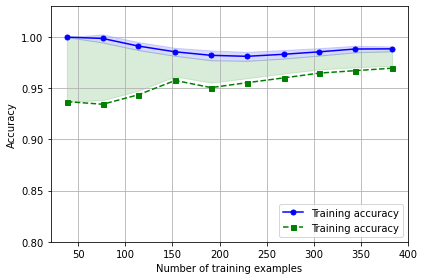

In [14]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

standardizer = StandardScaler()
lr = LogisticRegression()
pipeline = make_pipeline(standardizer, lr)

train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline,
                                                        X=X_train, y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, test_mean+train_std, train_mean-train_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

#### 検証曲線


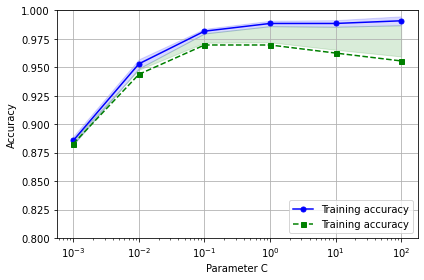

In [15]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

standardizer = StandardScaler()
lr = LogisticRegression()
pipeline = make_pipeline(standardizer, lr)

train_scores, test_scores = validation_curve(estimator=pipeline,
                                             X=X_train, y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Training accuracy')
plt.fill_between(param_range, test_mean+train_std, train_mean-train_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

### 性能評価指標
#### 混同行列
混同行列は、分類器の真陽性(True Positive)、真陰性(True Negative)、偽陽性(False Positive)、偽陰性(False Negative)の個数を要素とする行列である。

[[55  1]
 [ 1 86]]


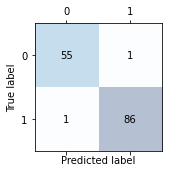

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

**誤分類率(ERR)**は、誤った予測の合計を予測の総数で割ったもの、  
**正解率(ACC)**は、正しい予測の合計を予測の総数で割ったものである。
$$
\begin{align}
ERR&=\frac{FP+FN}{FP+FN+TP+TN}\\
ACC&=\frac{TP+TN}{FP+FN+TP+TN}=1-ERR
\end{align}
$$

**真陽性率(TPR)**と**偽陽性率(FPR)**は、不均衡なクラスの際に役立つ指標である。  
$$
FPR=\frac{FP}{N}=\frac{FP}{FP+TN}\\
TPR=\frac{TP}{P}=\frac{TP}{FN+TP}
$$

**適合率(PRE)**は、陽性と予測したデータ点のうち、実際に陽性であったデータの割合、  
**再現率(REC)**は、陽性クラスのデータ点のうち、実際に陽性と予測されたデータ点の割合であり、TPRと同義である。 
$$
\begin{align}
PRE&=\frac{TP}{TP+FP}\\
REC&=TPR=\frac{TP}{P}=\frac{TP}{FN+TP}
\end{align}
$$

再現率の最適化は不検出を最小化するのに役立つが、偽陽性を増やす可能性がある。  
適合率の最適化は陽性であるという予測の正確さえお強化できるが、不検出(偽陰性)を頻繁に起こす。  
PREとRECのバランスをとるために、**F1スコア(F1-score)**がよく使われる。
$$
F1=2\frac{PRE×REC}{PRE+REC}
$$

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.989
Recall: 0.989
F1: 0.989


#### ROC(受信者操作特性)曲線
分類器の閾値を変えることによって計算される偽陽性率と真陽性率の選択の基準となる。  
ROC曲線の対角線は当て推量(ランダムな推定)として解釈でき、対角線を下回る分類モデルは当て推量よりも劣るとみなされる。  
完璧な分類器はグラフの左上隅に位置付けられ、TPRは1FPRは0となる。  
性能の評価には**AUC(曲線下面積)**を用いる。

AUC:  0.8552955665024631


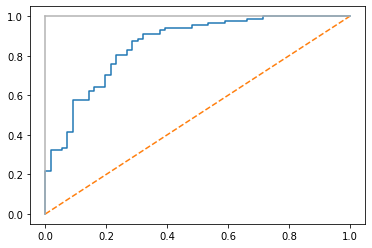

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

pipeline.fit(X_train.iloc[:,9:11], y_train)
y_probabilities = pipeline.predict_proba(X_test.iloc[:,9:11])[:,1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_probabilities)

plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
print('AUC: ',roc_auc_score(y_test, y_probabilities))

#### 適合率-再現率曲線

Text(0, 0.5, 'Recall')

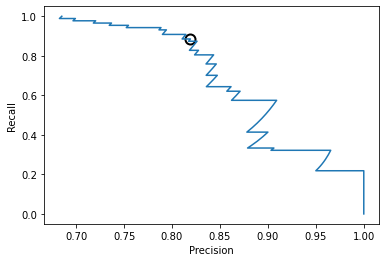

In [39]:
from sklearn.metrics import precision_recall_curve

y_probabilities = pipeline.decision_function(X_test.iloc[:,9:11])

precision, recall, thresholds = precision_recall_curve(y_test, y_probabilities)

close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

#### 多クラス分類のための性能指標
**マイクロ法**と**マクロ法**があり、これらは**一体全**分類を通じてそれらの性能指標を多クラス問題に拡張するものである。
#### マイクロ平均法
各インスタンスまたは予測を平等に重み付けしたい場合に役立つ。  
$k$クラス問題での適合率のマイクロ平均は次のように求められる。
$$
PRE_{micro}=\frac{TP_1+\cdots+TP_k}{TP_1+\cdots+TP_k+FP_1+\cdots+FP_k}
$$
  
#### マクロ平均法
最も出現するクラスラベルに過度の影響を受けることなく分類器の全体的な性能を評価するために、すべてのクラスに平等に重み付けをする。  
マクロ平均はそれぞれの問題の性能指標の平均として求める。  
$$
PRE_{macro}=\frac{PRE_1+\cdots+PRE_k}{k}
$$

In [42]:
from sklearn.metrics import make_scorer

pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1, 
                         greater_is_better=True,
                         average='micro')

全解探索

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [5]:
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

lr = linear_model.LogisticRegression()

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
params = dict(C=C, penalty=penalty)

gridsearch = GridSearchCV(lr, params, cv=5, verbose=0)

best_model = gridsearch.fit(X_train, y_train)

In [6]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 7.742636826811269


In [7]:
print(best_model.predict(X_test))
print(y_test)

[2 0 1 1 0 1 1 2 0 2 1 1 0 0 0 2 0 0 2 2 0 0 2 1 2 2 0 2 2 2 1 1 1 0 0 2 1
 0 1 1 2 1 1 2 0]
[2 0 1 1 0 1 1 2 0 2 1 1 0 0 0 2 0 0 2 2 0 0 2 1 2 2 0 2 2 2 1 1 1 0 0 2 1
 0 1 1 2 1 1 2 0]


ランダム探索

In [8]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

randomizedsearch = RandomizedSearchCV(lr, params, n_iter=100, cv=5, verbose=0)

best_model = randomizedsearch.fit(X_train, y_train)

In [9]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 7.742636826811269


In [12]:
print(best_model.predict(X_test))
print(y_test)

[1 0 0 1 1 1 1 0 2 2 1 0 2 2 0 1 2 0 0 1 2 0 2 1 1 0 0 2 2 1 2 0 2 1 0 0 0
 1 2 1 0 2 1 2 1]
[1 0 0 2 1 1 1 0 2 2 1 0 2 2 0 1 2 0 0 1 2 0 2 1 1 0 0 2 2 1 2 0 2 1 0 0 0
 1 2 1 0 2 1 2 1]


複数のアルゴリズムから最良のモデルの選択

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([("classifier", RandomForestClassifier())])

search_space = [{"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l1', 'l2'],
                 "classifier__C": np.logspace(0, 4, 10)},
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_features": [1, 2, 3]}]

gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)

best_model = gridsearch.fit(X_train, y_train)

In [11]:
best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier', LogisticRegression(C=7.742636826811269))],
 'verbose': False,
 'classifier': LogisticRegression(C=7.742636826811269),
 'classifier__C': 7.742636826811269,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [12]:
print(best_model.predict(X_test))
print(y_test)

[2 0 1 1 0 1 1 2 0 2 1 1 0 0 0 2 0 0 2 2 0 0 2 1 2 2 0 2 2 2 1 1 1 0 0 2 1
 0 1 1 2 1 1 2 0]
[2 0 1 1 0 1 1 2 0 2 1 1 0 0 0 2 0 0 2 2 0 0 2 1 2 2 0 2 2 2 1 1 1 0 0 2 1
 0 1 1 2 1 1 2 0]


前処理がある場合の最良モデルの選択

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#-----
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
# ColumnTransformer([('transparent', FunctionTransformer(lambda x: x, validate=False), [i for i, _ in enumerate(X_df)])])


preprocess = FeatureUnion([("std", StandardScaler()), ("pca", PCA())])

pipe = Pipeline([("preprocess", preprocess),
                 ("classifier", LogisticRegression())])

search_space = [{"preprocess__pca__n_components": [1, 2, 3],
                 "classifier__penalty": ["l1", "l2"],
                 "classifier__C": np.logspace(0, 4, 10)}]

clf = GridSearchCV(pipe, search_space, cv=5, verbose=0, n_jobs=-1)

best_model = clf.fit(X_train, y_train)

In [14]:
best_model.best_estimator_.get_params()['preprocess__pca__n_components']

1

In [15]:
print(best_model.predict(X_test))
print(y_test)

[2 0 1 1 0 1 1 2 0 2 1 1 0 0 0 2 0 0 2 2 0 0 2 2 2 2 0 2 2 2 1 1 1 0 0 2 1
 0 1 1 2 1 1 2 0]
[2 0 1 1 0 1 1 2 0 2 1 1 0 0 0 2 0 0 2 2 0 0 2 1 2 2 0 2 2 2 1 1 1 0 0 2 1
 0 1 1 2 1 1 2 0]


モデル選択後の性能評価  
二重交差検証

In [22]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()

C = np.logspace(0, 4, 10)

params = dict(C=C)

gridsearch = GridSearchCV(lr, params, cv=5, n_jobs=-1, verbose=0)
cross_val_score(gridsearch, X_train, y_train).mean()

0.9333333333333333

In [18]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
features = cancer.data
target = cancer.target

X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)

## ベイズ最適化

In [19]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import log_loss
import xgboost as xgb



def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['silent'] = 1
   
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    
    gbm_model = xgb.train(params, dtrain,
                          evals=watchlist,
                          verbose_eval=True)
    
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = log_loss(y_val, predictions)
    print(f'params: {params}, logloss: {score:.4f}')
    #history.append(params, score)
    
    return {'loss': score, 'status': STATUS_OK}

In [20]:
param_space = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
    'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0))
}

max_evals= 10
trials = Trials()
history = []
best = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

[09:59:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541:                   
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:59:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-logloss:0.50507	train-logloss:0.45520                                                                         

[1]	eval-logloss:0.39188	train-logloss:0.31894                                                                         

[2]	eval-logloss:0.31529	train-logloss:0.23394

[0]	eval-logloss:0.51019	train-logloss:0.44703                                                                         

[1]	eval-logloss:0.40885	train-logloss:0.31092                                                                         

[2]	eval-logloss:0.32939	train-logloss:0.22461                                                                         

[3]	eval-logloss:0.28067	train-logloss:0.16482                                                                         

[4]	eval-logloss:0.24948	train-logloss:0.12565                                                                         

[5]	eval-logloss:0.22532	train-logloss:0.09459                                                                         

[6]	eval-logloss:0.20396	train-logloss:0.07250                                                                         

[7]	eval-logloss:0.18934	train-logloss:0.05566                                                                         

[8]	eval-logloss:0.18311	train-l

In [27]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)
num_round = 50

best['max_depth'] = int(best['max_depth'])
best['booster'] = 'gbtree'
best['objective'] = 'binary:logistic'

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(best, dtrain, num_round, evals=watchlist, early_stopping_rounds=20)

va_pred = model.predict(dvalid)
score = log_loss(y_val, va_pred)
print(score)

pred = model.predict(dtest)
print(np.sum((pred>=0.5)==(y_test))/len(y_test))

[11:42:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.46677	eval-logloss:0.49023
[1]	train-logloss:0.33420	eval-logloss:0.37897
[2]	train-logloss:0.24816	eval-logloss:0.30992
[3]	train-logloss:0.19085	eval-logloss:0.26406
[4]	train-logloss:0.15025	eval-logloss:0.23465
[5]	train-logloss:0.11768	eval-logloss:0.21631
[6]	train-logloss:0.09444	eval-logloss:0.20829
[7]	train-logloss:0.07859	eval-logloss:0.19361
[8]	train-logloss:0.06325	eval-logloss:0.18541
[9]	train-logloss:0.05470	eval-logloss:0.18624
[10]	train-logloss:0.04754	eval-logloss:0.17450
[11]	train-logloss:0.04037	eval-logloss:0.17341
[12]	train-logloss:0.03385	eval-logloss:0.16815
[13]	train-logloss:0.02909	eval-logloss:0.17200
[14]	train-logloss:0.02560	e

# optunaによる最適化

In [21]:
from functools import partial

import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn import datasets


def objective(X, y, trial):
    """最小化する目的関数"""
    params = {
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'sigmoid']),
        'C': trial.suggest_loguniform('C', 1e+0, 1e+2),
        'gamma': trial.suggest_loguniform('gamma', 1e-2, 1e+1),
    }

    # モデルを作る
    model = SVC(**params)

    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X=X, y=y, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return 1.0 - scores['test_score'].mean()


def main():
    # 目的関数にデータを適用する
    f = partial(objective, X_train, y_train)
    # 最適化のセッションを作る
    study = optuna.create_study()
    # 100 回試行する
    study.optimize(f, n_trials=100)
    # 最適化したパラメータを出力する
    print('params:', study.best_params)


if __name__ == '__main__':
    main()

params: {'kernel': 'rbf', 'C': 20.84532688788379, 'gamma': 0.010146030481205121}


複数モデルからの選択

In [22]:
from functools import partial

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn import datasets

optuna.logging.disable_default_handler()

def objective(X, y, trial):
    """最小化する目的関数"""

    # 使う分類器は SVM or RF
    classifier = trial.suggest_categorical('classifier', ['SVC', 'RandomForestClassifier'])

    # 選ばれた分類器で分岐する
    if classifier == 'SVC':
        # SVC のとき
        params = {
            'kernel': trial.suggest_categorical('kernel', ['rbf', 'sigmoid']),
            'C': trial.suggest_loguniform('C', 1e+0, 1e+2),
            'gamma': trial.suggest_loguniform('gamma', 1e-2, 1e+1),
        }
        model = SVC(**params)
    else:
        # RF のとき
        params = {
            'n_estimators': int(trial.suggest_int('n_estimators', 1e+2, 1e+3, log=True)),
            'max_depth': int(trial.suggest_int('max_depth', 2, 32, log=True)),
        }
        model = RandomForestClassifier(**params)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X=X, y=y, cv=kf, n_jobs=-1)
    return 1.0 - scores['test_score'].mean()

In [23]:
f = partial(objective, X_train, y_train)
study = optuna.create_study()
study.optimize(f, n_trials=100)
print('params:', study.best_params)

params: {'classifier': 'RandomForestClassifier', 'n_estimators': 745, 'max_depth': 14}


In [38]:
d=study.best_params
del d['classifier']
d

{'n_estimators': 172, 'max_depth': 24}

In [40]:
model = RandomForestClassifier(**d)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.958041958041958